In [18]:
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
AUTOTUNE = tf.data.experimental.AUTOTUNE

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.2.0-rc4
Eager mode:  True
Hub version:  0.8.0
GPU is available


In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))





#splits, info = tfds.load('cars196', with_info=True, as_supervised=True,  split=['train[:30%]', 'test[:10%]'])
splits, info = tfds.load('cars196', with_info=True, as_supervised=True,  split=['train', 'test'])

(train_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes



In [21]:
print(info)

tfds.core.DatasetInfo(
    name='cars196',
    version=2.0.0,
    description='The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.',
    homepage='https://ai.stanford.edu/~jkrause/cars/car_dataset.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
    }),
    total_num_examples=16185,
    splits={
        'test': 8041,
        'train': 8144,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{KrauseStarkDengFei-Fei_3DRR2013,
      title = {3D Object Representations for Fine-Grained Categorization},
      booktitle = {4th International IEEE Worksh

In [0]:
IMAGE_SIZE = 224
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE)) / 255.0
  return  image, label
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label
def augment(image,label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image - tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
  image = tf.image.resize_with_crop_or_pad(image, 250, 250) # Add 6 pixels of padding
  image = tf.image.random_crop(image, size=[IMAGE_SIZE, IMAGE_SIZE, 3]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

  return image,label


In [0]:
BATCH_SIZE =  250#@param {type:"integer"}

In [0]:
train_batches = train_examples.shuffle(num_examples // 4).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE).repeat()
validation_batches = test_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
#test_batches = test_examples.batch(1).map(format_image)

In [25]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([1500, 224, 224, 3])

In [0]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [27]:
URL = "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

feature_extractor.trainable = False

model = tf.keras.Sequential([
  feature_extractor,
  #tf.keras.layers.Dense(Flatten()),  # this converts our 3D feature maps to 1D feature vectors
  tf.keras.layers.Dense(1000,activation='relu'),
  tf.keras.layers.Dense(512,activation='relu') ,
  tf.keras.layers.Dense(196, activation='softmax')
])

model.summary()

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              58331648  
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_4 (Dense)              (None, 196)               100548    
Total params: 60,993,708
Trainable params: 2,662,060
Non-trainable params: 58,331,648
_________________________________________________________________


In [0]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(300,300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.summary()

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 147, 147, 64)      36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 33, 33, 128)      

In [28]:
history = model.fit(train_batches, epochs=25, steps_per_epoch=10, validation_data = validation_batches,  validation_steps=3)

model.save("cars196.h5")

Epoch 1/150
10/10 [==============================] - 71s 7s/step - loss: 5.1917 - accuracy: 0.0213 - val_loss: 4.7719 - val_accuracy: 0.0447
Epoch 2/150
10/10 [==============================] - 70s 7s/step - loss: 4.4899 - accuracy: 0.0724 - val_loss: 4.5771 - val_accuracy: 0.0678
Epoch 3/150
10/10 [==============================] - 62s 6s/step - loss: 4.0776 - accuracy: 0.1222 - val_loss: 4.4420 - val_accuracy: 0.0798
Epoch 4/150
10/10 [==============================] - 64s 6s/step - loss: 3.8252 - accuracy: 0.1575 - val_loss: 4.0435 - val_accuracy: 0.1298
Epoch 5/150
10/10 [==============================] - 78s 8s/step - loss: 3.5647 - accuracy: 0.2006 - val_loss: 4.0095 - val_accuracy: 0.1347
Epoch 6/150
10/10 [==============================] - 61s 6s/step - loss: 3.3688 - accuracy: 0.2373 - val_loss: 4.4626 - val_accuracy: 0.1151
Epoch 7/150
10/10 [==============================] - 66s 7s/step - loss: 3.2193 - accuracy: 0.2625 - val_loss: 3.9894 - val_accuracy: 0.1680
Epoch 8/150
1

KeyboardInterrupt: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive')

model.save('/content/drive/My Drive/Machine_Learning/Models/cars196_model/cars196_High_train_acc_better_val_acc1.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

new_model = tf.keras.models.load_model('rpsOne.h5',custom_objects={'KerasLayer':hub.KerasLayer})
new_model.summary()
model = new_model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              60382697  
_________________________________________________________________
dense_1 (Dense)              (None, 196)               196392    
Total params: 60,579,089
Trainable params: 196,392
Non-trainable params: 60,382,697
_________________________________________________________________


In [0]:
classes = model.predict()

In [0]:
from PIL import Image
import numpy as np
from skimage import transform
def load(np_image):
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (150,150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

for example in train_examples:
  image,label = example
  print(label)
  #print(image)
  result = model.predict(load(image))
  predicted_batch = tf.squeeze(result).numpy()
  print(predicted_batch)
  predicted_ids = np.argmax(predicted_batch, axis=-1)
  print(predicted_ids[0])
  predicted_class_names = _NAMES[predicted_ids[0]]

  print(predicted_class_names)
  break

tf.Tensor(194, shape=(), dtype=int64)


AttributeError: ignored

In [0]:

_NAMES = [
    'AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012',
    'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001',
    'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012',
    'Aston Martin V8 Vantage Coupe 2012',
    'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012',
    'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012',
    'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994',
    'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011',
    'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012',
    'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012',
    'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012',
    'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012',
    'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007',
    'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW M3 Coupe 2012',
    'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012',
    'BMW Z4 Convertible 2012',
    'Bentley Continental Supersports Conv. Convertible 2012',
    'Bentley Arnage Sedan 2009', 'Bentley Mulsanne Sedan 2011',
    'Bentley Continental GT Coupe 2012', 'Bentley Continental GT Coupe 2007',
    'Bentley Continental Flying Spur Sedan 2007',
    'Bugatti Veyron 16.4 Convertible 2009', 'Bugatti Veyron 16.4 Coupe 2009',
    'Buick Regal GS 2012', 'Buick Rainier SUV 2007', 'Buick Verano Sedan 2012',
    'Buick Enclave SUV 2012', 'Cadillac CTS-V Sedan 2012',
    'Cadillac SRX SUV 2012', 'Cadillac Escalade EXT Crew Cab 2007',
    'Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
    'Chevrolet Corvette Convertible 2012', 'Chevrolet Corvette ZR1 2012',
    'Chevrolet Corvette Ron Fellows Edition Z06 2007',
    'Chevrolet Traverse SUV 2012', 'Chevrolet Camaro Convertible 2012',
    'Chevrolet HHR SS 2010', 'Chevrolet Impala Sedan 2007',
    'Chevrolet Tahoe Hybrid SUV 2012', 'Chevrolet Sonic Sedan 2012',
    'Chevrolet Express Cargo Van 2007', 'Chevrolet Avalanche Crew Cab 2012',
    'Chevrolet Cobalt SS 2010', 'Chevrolet Malibu Hybrid Sedan 2010',
    'Chevrolet TrailBlazer SS 2009',
    'Chevrolet Silverado 2500HD Regular Cab 2012',
    'Chevrolet Silverado 1500 Classic Extended Cab 2007',
    'Chevrolet Express Van 2007', 'Chevrolet Monte Carlo Coupe 2007',
    'Chevrolet Malibu Sedan 2007', 'Chevrolet Silverado 1500 Extended Cab 2012',
    'Chevrolet Silverado 1500 Regular Cab 2012', 'Chrysler Aspen SUV 2009',
    'Chrysler Sebring Convertible 2010',
    'Chrysler Town and Country Minivan 2012', 'Chrysler 300 SRT-8 2010',
    'Chrysler Crossfire Convertible 2008',
    'Chrysler PT Cruiser Convertible 2008', 'Daewoo Nubira Wagon 2002',
    'Dodge Caliber Wagon 2012', 'Dodge Caliber Wagon 2007',
    'Dodge Caravan Minivan 1997', 'Dodge Ram Pickup 3500 Crew Cab 2010',
    'Dodge Ram Pickup 3500 Quad Cab 2009', 'Dodge Sprinter Cargo Van 2009',
    'Dodge Journey SUV 2012', 'Dodge Dakota Crew Cab 2010',
    'Dodge Dakota Club Cab 2007', 'Dodge Magnum Wagon 2008',
    'Dodge Challenger SRT8 2011', 'Dodge Durango SUV 2012',
    'Dodge Durango SUV 2007', 'Dodge Charger Sedan 2012',
    'Dodge Charger SRT-8 2009', 'Eagle Talon Hatchback 1998',
    'FIAT 500 Abarth 2012', 'FIAT 500 Convertible 2012',
    'Ferrari FF Coupe 2012', 'Ferrari California Convertible 2012',
    'Ferrari 458 Italia Convertible 2012', 'Ferrari 458 Italia Coupe 2012',
    'Fisker Karma Sedan 2012', 'Ford F-450 Super Duty Crew Cab 2012',
    'Ford Mustang Convertible 2007', 'Ford Freestar Minivan 2007',
    'Ford Expedition EL SUV 2009', 'Ford Edge SUV 2012',
    'Ford Ranger SuperCab 2011', 'Ford GT Coupe 2006',
    'Ford F-150 Regular Cab 2012', 'Ford F-150 Regular Cab 2007',
    'Ford Focus Sedan 2007', 'Ford E-Series Wagon Van 2012',
    'Ford Fiesta Sedan 2012', 'GMC Terrain SUV 2012', 'GMC Savana Van 2012',
    'GMC Yukon Hybrid SUV 2012', 'GMC Acadia SUV 2012',
    'GMC Canyon Extended Cab 2012', 'Geo Metro Convertible 1993',
    'HUMMER H3T Crew Cab 2010', 'HUMMER H2 SUT Crew Cab 2009',
    'Honda Odyssey Minivan 2012', 'Honda Odyssey Minivan 2007',
    'Honda Accord Coupe 2012', 'Honda Accord Sedan 2012',
    'Hyundai Veloster Hatchback 2012', 'Hyundai Santa Fe SUV 2012',
    'Hyundai Tucson SUV 2012', 'Hyundai Veracruz SUV 2012',
    'Hyundai Sonata Hybrid Sedan 2012', 'Hyundai Elantra Sedan 2007',
    'Hyundai Accent Sedan 2012', 'Hyundai Genesis Sedan 2012',
    'Hyundai Sonata Sedan 2012', 'Hyundai Elantra Touring Hatchback 2012',
    'Hyundai Azera Sedan 2012', 'Infiniti G Coupe IPL 2012',
    'Infiniti QX56 SUV 2011', 'Isuzu Ascender SUV 2008', 'Jaguar XK XKR 2012',
    'Jeep Patriot SUV 2012', 'Jeep Wrangler SUV 2012', 'Jeep Liberty SUV 2012',
    'Jeep Grand Cherokee SUV 2012', 'Jeep Compass SUV 2012',
    'Lamborghini Reventon Coupe 2008', 'Lamborghini Aventador Coupe 2012',
    'Lamborghini Gallardo LP 570-4 Superleggera 2012',
    'Lamborghini Diablo Coupe 2001', 'Land Rover Range Rover SUV 2012',
    'Land Rover LR2 SUV 2012', 'Lincoln Town Car Sedan 2011',
    'MINI Cooper Roadster Convertible 2012',
    'Maybach Landaulet Convertible 2012', 'Mazda Tribute SUV 2011',
    'McLaren MP4-12C Coupe 2012', 'Mercedes-Benz 300-Class Convertible 1993',
    'Mercedes-Benz C-Class Sedan 2012', 'Mercedes-Benz SL-Class Coupe 2009',
    'Mercedes-Benz E-Class Sedan 2012', 'Mercedes-Benz S-Class Sedan 2012',
    'Mercedes-Benz Sprinter Van 2012', 'Mitsubishi Lancer Sedan 2012',
    'Nissan Leaf Hatchback 2012', 'Nissan NV Passenger Van 2012',
    'Nissan Juke Hatchback 2012', 'Nissan 240SX Coupe 1998',
    'Plymouth Neon Coupe 1999', 'Porsche Panamera Sedan 2012',
    'Ram C/V Cargo Van Minivan 2012',
    'Rolls-Royce Phantom Drophead Coupe Convertible 2012',
    'Rolls-Royce Ghost Sedan 2012', 'Rolls-Royce Phantom Sedan 2012',
    'Scion xD Hatchback 2012', 'Spyker C8 Convertible 2009',
    'Spyker C8 Coupe 2009', 'Suzuki Aerio Sedan 2007',
    'Suzuki Kizashi Sedan 2012', 'Suzuki SX4 Hatchback 2012',
    'Suzuki SX4 Sedan 2012', 'Tesla Model S Sedan 2012',
    'Toyota Sequoia SUV 2012', 'Toyota Camry Sedan 2012',
    'Toyota Corolla Sedan 2012', 'Toyota 4Runner SUV 2012',
    'Volkswagen Golf Hatchback 2012', 'Volkswagen Golf Hatchback 1991',
    'Volkswagen Beetle Hatchback 2012', 'Volvo C30 Hatchback 2012',
    'Volvo 240 Sedan 1993', 'Volvo XC90 SUV 2007',
    'smart fortwo Convertible 2012',
]

In [0]:

image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
print(predicted_ids[0])
#predicted_class_names = _NAMES[predicted_ids]

#print(predicted_class_names)

[100 179  65  80  21 184  91 167 132   6  96  53 151 119 165  90 107  31
   4  35  46  50 181 143 171 113  63  83 156  96  35 152  86 124 107  31
 176  93   1   2  12  42  48 156  27   9 104  92  47 184  73 166 153  20
  31 167 137 130 121 129  39 131 144 194 119  41 131  52 172 164 118  12
 185  50 118  69  25 105   3 122 159 149 192  70  64 159 172  47  59  59
  22 160 184  13 120  39 114   8 153  13  48 157  73  78  45 147   8 171
 144  81  77  90  36 168  40  11 119  83 122 190  19 192 135   9  31  39
 178 146 149 183 100  49 177 195 127 112 170 170  33  63 131  95  32  81
 194  55  64   3 152  94 190  33 159  13 125  98 117 109  14  66 129 102
 112  51 123 147 103 112  50 155  18  95  79  93 136  47 110  93  52 137
   4 189  15  40 103 133   1  77 148 187  70 175  78 125  54   4   4 188
  14  34 163 166  71  97   3 179 111  41 100   8  50  73  77  49 113  27
 143  44 110 160  71 119  76 193 156  44  36  63 127  24   5 104 155  74
 142 192  70 123  83   5 136  10  96  66 148  83 13

33
BMW M3 Coupe 2012


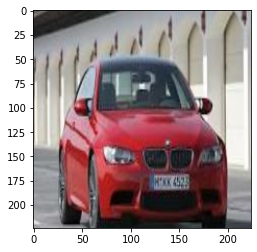

In [0]:
import matplotlib.pyplot as plt
for image_batch, label_batch in train_batches.take(1):
    #print(image_batch[0])
    #print(label_batch)
    image_index_in_batch = 1

    result = model.predict(image_batch)

    index_num = np.argmax(result[image_index_in_batch])

    print(index_num)
    print(_NAMES[index_num])
    plt.figure()
    plt.imshow(image_batch[image_index_in_batch])
    
    break
